In [1]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling
import datetime
import json
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import  accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.utils.multiclass import unique_labels
#import plotly.plotly as py
from sklearn.ensemble import RandomForestClassifier

In [2]:
 master = pd.DataFrame([[0]*37],columns=['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'creator', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'friends', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'location',
       'name', 'permissions', 'photo', 'pledged', 'profile', 'slug',
       'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'urls', 'usd_pledged', 'usd_type'])

In [3]:
for path in glob('Kickstarter_2019-08-15T03_20_03_022Z/*.csv'):
    df = pd.read_csv(path,error_bad_lines=False)
    master = pd.concat([df,master])

In [4]:
master.shape

(207622, 37)

In [5]:
# profile = master.profile_report(title='Pandas Profiling Report')
# profile.to_file(output_file="output.html")

In [6]:
master = master.drop(columns = ['friends','is_backing','is_starred','permissions','photo'
                               ,'currency_symbol','urls','source_url','id','name','slug'])

In [7]:
master.head()

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_trailing_code,current_currency,...,location,pledged,profile,spotlight,staff_pick,state,state_changed_at,static_usd_rate,usd_pledged,usd_type
0,104,Best value in Cortex-M programming & debugging...,"{""id"":334,""name"":""DIY Electronics"",""slug"":""tec...",4415,US,1507871679,"{""id"":1182544591,""name"":""Dmitry"",""is_registere...",USD,1,USD,...,"{""id"":2455920,""name"":""Mountain View"",""slug"":""m...",4415.0,"{""id"":3182251,""project_id"":3182251,""state"":""in...",0,0,failed,1535230179,1.000000,4415.000000,domestic
1,1,PARENTHOOD - The (Brand New!) Musical Revue is...,"{""id"":284,""name"":""Musical"",""slug"":""theater/mus...",1,GB,1535457814,"{""id"":419452966,""name"":""Emily Moody"",""is_regis...",GBP,0,USD,...,"{""id"":44418,""name"":""London"",""slug"":""london-gb""...",1.0,"{""id"":3458158,""project_id"":3458158,""state"":""in...",0,0,failed,1538052598,1.285752,1.285752,domestic
2,1,porting an app for identifying organic compoun...,"{""id"":332,""name"":""Apps"",""slug"":""technology/app...",1,NL,1525968644,"{""id"":1981812785,""name"":""Matthieu van Sluijs"",...",EUR,0,USD,...,"{""id"":726874,""name"":""The Hague"",""slug"":""the-ha...",1.0,"{""id"":3378332,""project_id"":3378332,""state"":""in...",0,0,failed,1537436992,1.173151,1.173151,domestic
3,62,I am a singer/songwriter from Miami Beach work...,"{""id"":42,""name"":""Pop"",""slug"":""music/pop"",""posi...",8211,US,1314912713,"{""id"":1503975448,""name"":""Cat Shell"",""slug"":""ca...",USD,1,USD,...,"{""id"":2450080,""name"":""Miami Beach"",""slug"":""mia...",8211.0,"{""id"":49312,""project_id"":49312,""state"":""inacti...",1,0,successful,1325310338,1.000000,8211.000000,domestic
4,34,Support your local DIY grunge grrrl band creat...,"{""id"":321,""name"":""Punk"",""slug"":""music/punk"",""p...",1700,US,1501983823,"{""id"":593243081,""name"":""Shrinking Violent"",""is...",USD,1,USD,...,"{""id"":2504633,""name"":""Tempe"",""slug"":""tempe-az""...",1700.0,"{""id"":3098727,""project_id"":3098727,""state"":""in...",1,0,successful,1506720698,1.000000,1700.000000,domestic


In [8]:
# need to get category and sub category for this. 
master['category'].head()[0]

'{"id":334,"name":"DIY Electronics","slug":"technology/diy electronics","position":4,"parent_id":16,"color":6526716,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/technology/diy%20electronics"}}}'

In [9]:
master['created_at'] = master['created_at'].apply(lambda x: datetime.datetime.fromtimestamp(x))
master['launched_at'] = master['launched_at'].apply(lambda x: datetime.datetime.fromtimestamp(x))
master['deadline'] = master['deadline'].apply(lambda x: datetime.datetime.fromtimestamp(x))
#master['deadline'] = master['deadline'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%c'))

In [10]:
master[['created_at','launched_at','deadline','state']].sample(10)

,created_at,launched_at,deadline,state
2241,2014-06-29 11:56:28,2014-07-11 18:10:07,2014-08-10 18:10:07,successful
3008,2017-01-22 20:04:40,2017-01-22 21:25:45,2017-02-21 20:04:00,successful
1805,2018-01-15 16:37:00,2018-03-16 21:28:46,2018-04-15 21:28:46,failed
2250,2011-01-15 15:23:16,2011-02-05 06:33:54,2011-03-07 06:33:54,successful
2186,2013-07-17 17:22:26,2013-08-02 20:44:53,2013-09-04 20:59:00,successful
1310,2018-03-23 15:42:59,2018-03-30 00:06:50,2018-04-30 23:59:00,successful
18,2012-09-23 12:59:13,2012-10-10 07:46:59,2012-11-09 07:46:59,successful
2817,2015-03-17 15:54:05,2015-03-26 14:49:02,2015-04-25 14:49:02,canceled
3035,2018-01-09 08:01:30,2018-05-01 06:07:45,2018-05-31 06:07:45,successful
3258,2017-05-19 02:05:50,2017-05-31 03:15:46,2017-06-10 03:15:46,successful


In [11]:
master['category'] = master['category'].astype(str)

In [12]:
master['category'] = master['category'].apply(json.loads)

In [13]:
df = pd.concat([master.drop(['category'], axis=1), master['category'].apply(pd.Series)], axis=1)

In [14]:
df[['slug','name']].head()

,slug,name
0,technology/diy electronics,DIY Electronics
1,theater/musical,Musical
2,technology/apps,Apps
3,music/pop,Pop
4,music/punk,Punk


In [15]:
df=df.drop(columns = ['name','parent_id','position','id','urls','color','state_changed_at'],axis =1)

In [16]:
new = df['slug'].str.split("/", n = 1, expand = True) 
df["category"]= new[0]
df["sub-category"] = new[1]
df.drop(columns =['slug'], inplace = True)

In [17]:
df[['category','sub-category']].head()

,category,sub-category
0,technology,diy electronics
1,theater,musical
2,technology,apps
3,music,pop
4,music,punk


In [18]:
df['campaign_duration'] = df['deadline'] - df['launched_at'] 
#type(df['launched_at'].head()[0])

In [19]:
df[['campaign_duration','deadline','launched_at','state']].head()

,campaign_duration,deadline,launched_at,state
0,60 days,2018-08-25 13:49:39,2018-06-26 13:49:39,failed
1,30 days,2018-09-27 05:49:57,2018-08-28 05:49:57,failed
2,60 days,2018-09-20 02:49:52,2018-07-22 02:49:52,failed
3,60 days,2011-12-30 21:45:36,2011-10-31 21:45:36,successful
4,52 days,2017-09-29 14:31:37,2017-08-08 14:31:37,successful


In [20]:
df['campaign_launch_delay'] = df['launched_at'] - df['created_at'] 

In [21]:
df['campaign_launch_delay'].head()

0   256 days 15:35:00
1     0 days 00:46:23
2    72 days 17:39:08
3    60 days 07:13:43
4     2 days 19:47:54
Name: campaign_launch_delay, dtype: timedelta64[ns]

In [22]:
df2 = df[df['state'] != ('live')]

In [23]:
df2['state'].value_counts()

successful    118183
failed         74143
canceled        8456
suspended        632
0                  1
Name: state, dtype: int64

In [24]:
df3 = df2[df2['state'] != 0]

In [25]:
df3['state'].value_counts()

successful    118183
failed         74143
canceled        8456
suspended        632
Name: state, dtype: int64

In [26]:
df3=df3.drop(columns = ['blurb'],axis =1)

In [27]:
df3['deadline'] = pd.to_datetime(df3['deadline'], infer_datetime_format=True)
df3['launched_at'] = pd.to_datetime(df3['launched_at'], infer_datetime_format=True)
#df3['campaign_launch_delay'] = pd.to_datetime(df3['campaign_launch_delay'], infer_datetime_format=True)
df3['created_at'] = pd.to_datetime(df3['created_at'], infer_datetime_format=True)

In [28]:
df3['campaign_duration_days']= df3['campaign_duration'].dt.days

In [29]:
df3['campaign_launch_delay_days']=df3['campaign_launch_delay'].dt.days

In [30]:
df3[['campaign_launch_delay_days','campaign_launch_delay']].head()

,campaign_launch_delay_days,campaign_launch_delay
0,256,256 days 15:35:00
1,0,0 days 00:46:23
2,72,72 days 17:39:08
3,60,60 days 07:13:43
4,2,2 days 19:47:54


In [31]:
df3['campaign_launch_delay_secs']=df3['campaign_launch_delay'].dt.seconds

In [32]:
df3['launched_at_year'] = df3['launched_at'].dt.year
df3['launched_at_month'] = df3['launched_at'].dt.month
df3['launched_at_day'] = df3['launched_at'].dt.day
df3['launched_at_hour'] = df3['launched_at'].dt.hour

In [33]:
df3['deadline_year'] = df3['deadline'].dt.year
df3['deadline_month'] = df3['deadline'].dt.month
df3['deadline_day'] = df3['deadline'].dt.day
df3['deadline_hour'] = df3['deadline'].dt.hour

In [34]:
df3['created_at_year'] = df3['created_at'].dt.year
df3['created_at_month'] = df3['created_at'].dt.month
df3['created_at_day'] = df3['created_at'].dt.day
df3['created_at_hour'] = df3['created_at'].dt.hour

In [35]:
df3=df3.drop(columns = ['deadline','launched_at','campaign_launch_delay','created_at',
                       'campaign_duration'],axis =1)

In [36]:
df3.columns

Index([             'backers_count',   'converted_pledged_amount',
                          'country',                    'creator',
                         'currency',     'currency_trailing_code',
                 'current_currency',      'disable_communication',
                          'fx_rate',                       'goal',
                     'is_starrable',                   'location',
                          'pledged',                    'profile',
                        'spotlight',                 'staff_pick',
                            'state',            'static_usd_rate',
                      'usd_pledged',                   'usd_type',
                                  0,                   'category',
                     'sub-category',     'campaign_duration_days',
       'campaign_launch_delay_days', 'campaign_launch_delay_secs',
                 'launched_at_year',          'launched_at_month',
                  'launched_at_day',           'launched_at_ho

In [37]:
numerical_features = ['backers_count','converted_pledged_amount','fx_rate','goal','pledged',
                     'static_usd_rate','usd_pledged','launched_at_year','campaign_duration_days',
                     'launched_at_month','launched_at_day','launched_at_hour','deadline_year',
                     'deadline_month','created_at_year','created_at_month','created_at_day',
                     'created_at_hour','campaign_launch_delay_days','campaign_launch_delay_secs']
cat_features = ['country','creator','currency','current_currency','location','profile',
               'usd_type','category','sub-category']
bool_features = ['currency_trailing_code','disable_communication','is_starrable',
                'spotlight','staff_pick']

In [38]:
df3['created_at_year'].value_counts()

2015    36896
2018    33011
2016    29127
2017    28778
2014    28476
2019    19417
2013    11219
2012     8951
2011     3933
2010     1362
2009      244
Name: created_at_year, dtype: int64

In [39]:
df4 = df3[df3['state'] != 'canceled']

In [40]:
df5 = df4[df4['state'] != 'suspended']

In [80]:
df5.isnull().count()

backers_count                 192326
converted_pledged_amount      192326
country                       192326
creator                       192326
currency                      192326
currency_trailing_code        192326
current_currency              192326
disable_communication         192326
fx_rate                       192326
goal                          192326
is_starrable                  192326
location                      192326
pledged                       192326
profile                       192326
spotlight                     192326
staff_pick                    192326
state                         192326
static_usd_rate               192326
usd_pledged                   192326
usd_type                      192326
0                             192326
category                      192326
sub-category                  192326
campaign_duration_days        192326
campaign_launch_delay_days    192326
campaign_launch_delay_secs    192326
launched_at_year              192326
l

**Test Train Split**

In [41]:
#train, test = train_test_split(df3,stratify=df3['state'], random_state=42)

In [42]:
train = df5[df5['launched_at_year'] != 2019]
test = df5[df5['launched_at_year'] == 2019]

In [43]:
target = 'state'
X_train = train.drop(columns=target)
X_test = test.drop(columns=target)
y_test = test[target]
y_train = train[target]

In [44]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((169383, 37), (22943, 37), (169383,), (22943,))

In [45]:
# numeric_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())])
# ordinal_transformer = Pipeline(steps=[
#     #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('ord', ce.OrdinalEncoder())]) 
# boolean_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent'))])
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numerical_features),
#         ('one', ordinal_transformer, cat_features)])

In [46]:
# classification = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('rf', RandomForestClassifier(n_estimators=200, min_samples_split=3,
#                              criterion='gini', max_features='auto', oob_score=True,
#                              random_state=5, n_jobs=-1,class_weight = 'balanced'))])

In [47]:
# model = XGBClassifier(n_jobs=-1, random_state=42)
# param_dist = {'max_depth': randint(3,12),
#               'learning_rate': uniform(0,1),
#               'n_estimators': randint(200, 1500),
#               'min_child_weight': randint(1,10),
#               'gamma': randint(0,5),
#               'subsample': [0.6, 0.7, 0.8, 0.9, 1],
#               'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
#               }

# search = RandomizedSearchCV(model,
#                             param_distributions=param_dist,
#                             n_iter=10,
#                             cv=5,
#                             scoring='accuracy',
#                             verbose=10,
#                             return_train_score=True)

# search.fit(X_train, y_train)
# print('Best hyperparameters', search.best_params_)
# print('Best score', search.best_score_)

In [ ]:
imputer = SimpleImputer(stratergy = 'constant')

In [73]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.fit_transform(X_test)

In [74]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=3,
                            criterion='gini', max_features='auto', oob_score=True,
                              random_state=5, n_jobs=-1,class_weight = 'balanced')

In [75]:
# X_train_encoded.shape()

In [76]:
model.fit(X_train_encoded, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [51]:
# pre = Pipeline(steps=[('preprocessor', preprocessor)])

In [52]:
# X_test_encoded = pre.fit_transform(X_test)

In [53]:
# X_test_encoded.shape

In [54]:
# y_train.value_counts()

In [55]:
# y_test.value_counts()

In [56]:
# classification.named_steps['rf'].input_features_

In [57]:
# X_test.columns

In [59]:
 y_pred = model.predict(X_test[numerical_features])
print('test accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

test accuracy: 0.9957285446541428
              precision    recall  f1-score   support

      failed       1.00      0.98      0.99      4428
  successful       1.00      1.00      1.00     18515

   micro avg       1.00      1.00      1.00     22943
   macro avg       1.00      0.99      0.99     22943
weighted avg       1.00      1.00      1.00     22943



In [60]:
np.unique(y_pred)

array(['failed', 'successful'], dtype=object)

In [61]:
np.unique(y_test)

array(['failed', 'successful'], dtype=object)

In [62]:
# # choosing hyperparamters
# model = XGBClassifier()

# classification_hyp = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('model', XGBClassifier(n_jobs=-1,random_state = 42))])

# param_dist = {'model__max_depth': randint(3,12),
#               'model__n_estimators': randint(200, 1500),
#               'model__min_child_weight': randint(1,10),
#               'model__subsample': [0.6, 0.7, 0.8, 0.9, 1],
#               'model__learning_rate': uniform(0,1),
#               'model__gamma': randint(0,5),
#               'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1]
#               }

# search = RandomizedSearchCV(classification_hyp,
#                             param_distributions=param_dist,
#                             n_iter=5,
#                             cv=3,
#                             scoring='accuracy',
#                             verbose=10,
#                             return_train_score=True)

# search.fit(X_train, y_train)
# print('Best hyperparameters', search.best_params_)
# print('Best score', search.best_score_)

In [63]:
cm = confusion_matrix(y_test,y_pred)

In [64]:
def plot_confusion_matrix(y_true,y_pred,normalize=False):
    columns = [f'Predicted "{c}"'for c in unique_labels(y_pred)]
    index_names = [f'Actual "{c}"'for c in unique_labels(y_true)]
    cm = confusion_matrix(y_true,y_pred)
    if normalize:
        cm=cm/cm.sum(axis=1).reshape(y_true.nunique(),1)
    df = pd.DataFrame(cm,columns = columns,index = index_names)
    sns.heatmap(df,cmap='viridis',annot=True,fmt='.2f');

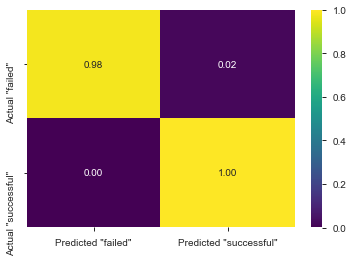

In [65]:
plot_confusion_matrix(y_test,y_pred,normalize=True)

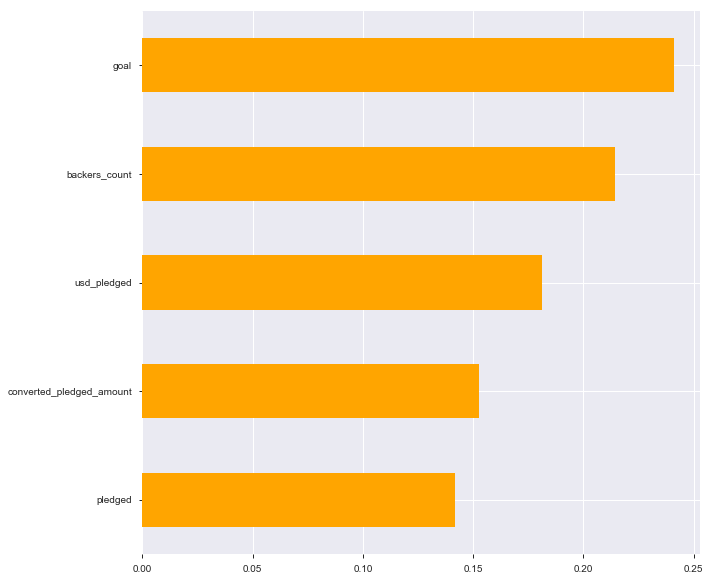

In [69]:
# Feature Importance
plt.figure(figsize=(10,10))
importances = pd.Series(model.feature_importances_, X_test[numerical_features].columns).sort_values(ascending=False)
importances = importances[:5].sort_values()
importances.plot.barh(color='orange');

Visuals

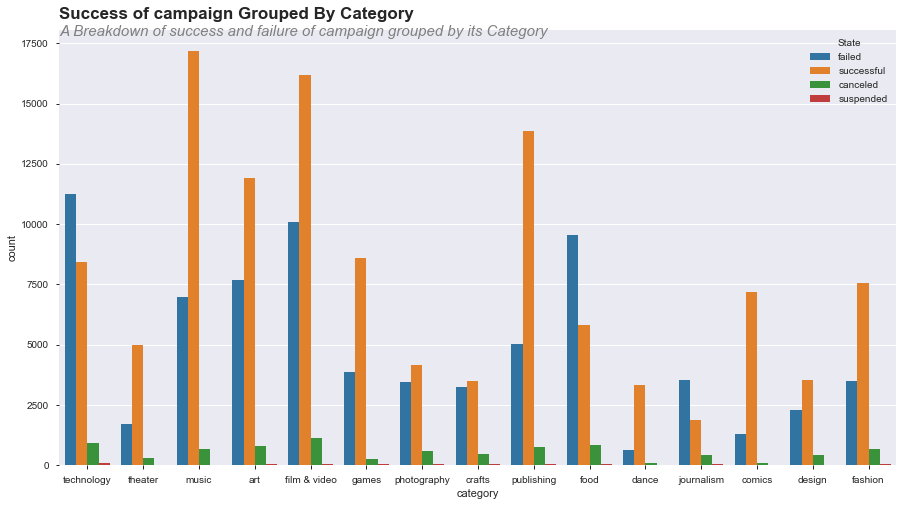

In [54]:
# Using the five thirty eight style
plt.style.context('fivethirtyeight')
#colors = ['#fff100', '#ff8c00', '#e81123', '#ec008c']
#sns.set_palette(colors, 4)
plt.figure(figsize=(15,8))

# Setting plot and details
ax = sns.countplot(x = "category", hue="state", data=df3)
ax.text(s="Success of campaign Grouped By Category", y=18500, x=-0.5, fontsize=17, fontweight='semibold');
ax.text(s="A Breakdown of success and failure of campaign grouped by its Category", y=17800, x=-0.5, fontsize=15, fontstyle='italic', color='grey')
l = ax.legend()
l.set_title('State')
sns.despine(ax=ax, left=True)
# ax.set_ylabel("");
# ax.set_xlabel("");

In [58]:
#ratio of success to fail in each category
#fail = df3[df3['state' == 'failed']]
fail = df3['state'=='failed']
success = df3['state'=='successful']
cancel = df3['state'=='canceled']

In [68]:
film_video = df3[df3['category']=='film & video']
music = df3['category'=='music']
technology = df3['category'=='technology']
art = df3['category'=='art']
publishing = df3['category'=='publishing']
food = df3['category'=='food']
games = df3['category'=='games']
fashion = df3['category'=='fashion']
comics = df3['category'=='comics']
photography = df3['category'=='photography']
crafts = df3['category'=='crafts']
theater = df3['category'=='theater']
design = df3['category'=='design']
journalism = df3['category'=='journalism']
dance = df3['category'=='dance']

In [81]:
(film_video[film_video['state']=='failed']['state'].count())/(film_video['state'].count())

0.36783329075581184